## Motivation <br>
We have chosen this topic to dwell on the rising concern of global warming and gain useful insights from the data that is available in the real world. <br>
We as data scientists, are trying to bring a change by predicting future temperature changes and making others aware of consequences they'll need to face. 

## Steps for Analysis <br>
1. Normalization and Visualization
2. Stationarization
    - Do a formal test of hypothesis
    - If series non stationary, stationarize
3. Explore Autocorrelations and Partial Autocorrelations
4. Build ARIMA Model
   - Identify training and test periods
   - Decide on model parameters
   - Compare models using accuracy measures
   - Make prediction

## Normalization <br>
### We have normalized the data into 5 different tables. <br>
`MajorCities` <br>
        `[CityID] INTEGER NOT NULL PRIMARY KEY,`<br>
        `[CityName] TEXT NOT NULL,` <br>
        `[Latitude] TEXT NOT NULL,`<br>
        `[Longitude] TEXT NOT NULL)`<br>
        <br>
`Country` <br>
`[CountryID] INTEGER NOT NULL PRIMARY KEY,` <br>
`[Country] TEXT NOT NULL)` <br>
<br>
`GlobalLandTemperatureByMajorCity`<br>
`[ID] INTEGER NOT NULL PRIMARY KEY,` <br>
`[Date] VARCHAR NOT NULL,` <br>
`[CityID] INTEGER NOT NULL,` <br>
`[CountryID] INTEGER NOT NULL,` <br>
`[AverageTemperature] REAL,` <br>
`[AverageTemperatureUncertainity] REAL,` <br>
`FOREIGN KEY(CityID) REFERENCES MajorCities(CityID),` <br>
`FOREIGN KEY(CountryID) REFERENCES Country(CountryID)` <br>
<br>
`GlobalLandTemperatureByCountry` <br>
`[ID] INTEGER NOT NULL PRIMARY KEY,` <br>
`[Date] VARCHAR NOT NULL,` <br>
`[Country] TEXT NOT NULL,` <br>
`[AverageTemperature] REAL,` <br>
`[AverageTemperatureUncertainity] REAL)` <br>
<br>
`GlobalTemperatures` <br>
`[ID] INTEGER NOT NULL PRIMARY KEY,` <br>
`[Date] VARCHAR NOT NULL,` <br>
`[AverageTemperature] REAL,` <br>
`[AverageTemperatureUncertainity] REAL)` <br>
<br>


In [2]:
#Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import sqlite3
from sqlite3 import Error
from datetime import datetime
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets

In [4]:
#Defining required functions for Data Manipulation

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

In [5]:
#Creating Major Cities Table

db_file_name = 'normalized_Temperature.db'
conn = create_connection(db_file_name)
cur = conn.cursor()

header = None
Cities = []
Countries = []
MCities = []
with open('GlobalLandTemperaturesByMajorCity.csv', 'r') as file:
    count = 1
    for line in file:
        if not line.strip(): # used for skipping empty lines!
            continue
        if header is None:
            header = line.strip().split(',')[0:7]
            continue
        temp_lst = line.strip().split(',')
        Cities.append(temp_lst)
        if temp_lst[4] not in Countries:
            Countries.append(temp_lst[4])
        if (temp_lst[3], temp_lst[5], temp_lst[6]) not in MCities:
            MCities.append((temp_lst[3], temp_lst[5], temp_lst[6]))


Cities.sort()

#Creating Major City Table 
sql_query = '''CREATE TABLE [MajorCities](
                [CityID] INTEGER NOT NULL PRIMARY KEY,
                [CityName] TEXT NOT NULL,
                [Latitude] TEXT NOT NULL,
                [Longitude] TEXT NOT NULL)
            '''
create_table(conn, sql_query)


# Inserting into Major City Table
with conn:
    cur = conn.cursor()
    cur.executemany('''INSERT INTO MajorCities(CityName, Latitude, Longitude)
                        VALUES (?,?,?)''',MCities )

#Creating Country Table 
sql_query = '''CREATE TABLE [Country](
                [CountryID] INTEGER NOT NULL PRIMARY KEY,
                [Country] TEXT NOT NULL)
            '''
create_table(conn, sql_query)

table [MajorCities] already exists
table [Country] already exists


In [6]:
# Inserting into Major City Table

with conn:
    cur = conn.cursor()
    cur.executemany('''INSERT INTO MajorCities(CityName, Latitude, Longitude)
                        VALUES (?,?,?)''',MCities )

In [7]:
#Creating Country Table 

sql_query = '''CREATE TABLE [Country](
                [CountryID] INTEGER NOT NULL PRIMARY KEY,
                [Country] TEXT NOT NULL)
            '''
create_table(conn, sql_query)

Country_list = []
for c in Countries:
    Country_list.append((c, ))

Country_list.sort()

table [Country] already exists


In [8]:
# Inserting into Country Table
with conn:
    cur = conn.cursor()
    cur.executemany('''INSERT INTO Country(Country)
                        VALUES (?)''',Country_list )


In [9]:
# Creating Major Cities dictionary
sql_statement = """ SELECT CityID, CityName FROM MajorCities; """
cityrows = execute_sql_statement(sql_statement, conn)
city_dict = {}
for r in cityrows:
    city_dict[r[1]] = r[0]

In [10]:
# Creating dictionary mapping country to country ID
sql_statement = """ SELECT * FROM Country; """
countryrows = execute_sql_statement(sql_statement, conn)
country_dict = {}
for r in countryrows:
    country_dict[r[1]] = r[0]

In [11]:
# Creating GlobalLandTemperatureByMajorCity Table
query = '''CREATE TABLE [GlobalLandTemperatureByMajorCity](
                [ID] INTEGER NOT NULL PRIMARY KEY,
                [Date] VARCHAR NOT NULL,
                [CityID] INTEGER NOT NULL,
                [CountryID] INTEGER NOT NULL,
                [AverageTemperature] REAL,
                [AverageTemperatureUncertainity] REAL,
                FOREIGN KEY(CityID) REFERENCES MajorCities(CityID),
                FOREIGN KEY(CountryID) REFERENCES Country(CountryID)
                )
            '''
create_table(conn, query)
majorcityrecords = []

for i in range(len(Cities)):
    if int(Cities[i][0][0:4]) < 1900:
        continue
    if Cities[i][1] == '' or Cities[i][2] == '':
        continue
    majorcityrecords.append((datetime.strptime(Cities[i][0], '%Y-%m-%d').strftime('%Y-%m-%d'), city_dict.get(Cities[i][3]), country_dict.get(Cities[i][4]), round(float(Cities[i][1]), 2), round(float(Cities[i][2]),2)))

with conn:
    cur.executemany('''INSERT INTO GlobalLandTemperatureByMajorCity(Date, CityID, CountryID, AverageTemperature, AverageTemperatureUncertainity)
                        VALUES (?,?,?,?,?)''', majorcityrecords)

table [GlobalLandTemperatureByMajorCity] already exists


In [12]:
# Creating GlobalLandTemperatureByCountry table
header = None
Countries = []
with open('GlobalLandTemperaturesByCountry.csv', 'r') as file:
    for line in file:
        if not line.strip(): # used for skipping empty lines!
            continue
        if header is None:
            header = line.strip().split(',')
            continue
        Countries.append(line.strip().split(','))

query = '''CREATE TABLE [GlobalLandTemperatureByCountry](
                [ID] INTEGER NOT NULL PRIMARY KEY,
                [Date] VARCHAR NOT NULL,
                `[Country] TEXT NOT NULL,`
                [AverageTemperature] REAL,
                [AverageTemperatureUncertainity] REAL)

            '''
create_table(conn, query)
countryrecords = []
for i in range(len(Countries)):
    if int(Countries[i][0][0:4]) < 1900:
        continue
    if Countries[i][1] == '' or Countries[i][2] == '':
        continue
    countryrecords.append((datetime.strptime(Countries[i][0], '%Y-%m-%d').strftime('%Y-%m-%d'), Countries[i][3], round(float(Countries[i][1]), 2), round(float(Countries[i][2]), 2)))

with conn:
    cur.executemany('''INSERT INTO GlobalLandTemperatureByCountry(Date, Country, AverageTemperature, AverageTemperatureUncertainity)
                        VALUES (?,?,?,?)''', countryrecords)

header = None
GlobalTemperatures = []
with open('GlobalTemperatures.csv', 'r') as file:
    for line in file:
        if not line.strip(): # used for skipping empty lines!
            continue
        if header is None:
            header = line.strip().split(',')[0:3]
            continue
        GlobalTemperatures.append(line.strip().split(',')[0:3])

query = '''CREATE TABLE [GlobalTemperatures](
                [ID] INTEGER NOT NULL PRIMARY KEY,
                [Date] VARCHAR NOT NULL,
                [AverageTemperature] REAL,
                [AverageTemperatureUncertainity] REAL)
            '''
create_table(conn, query)
globalrecords = []
for i in range(len(GlobalTemperatures)):
    if int(GlobalTemperatures[i][0][0:4]) < 1900:
        continue
    if GlobalTemperatures[i][1] == '' or GlobalTemperatures[i][2] == '':
        continue
    globalrecords.append((datetime.strptime(GlobalTemperatures[i][0], '%Y-%m-%d').strftime('%Y-%m-%d'), round(float(GlobalTemperatures[i][1]), 2), round(float(GlobalTemperatures[i][2]), 2)))

with conn:
    cur.executemany('''INSERT INTO GlobalTemperatures(Date, AverageTemperature, AverageTemperatureUncertainity)
                        VALUES (?,?,?)''', globalrecords)


table [GlobalLandTemperatureByCountry] already exists
table [GlobalTemperatures] already exists


### Exploratory Data Analysis.

In [13]:
# Printing Table MajorCities

sql_statement = """SELECT * FROM MajorCities"""
df = pd.read_sql_query(sql_statement, conn)
df

,CityID,CityName,Latitude,Longitude
0,1,Abidjan,5.63N,3.23W
1,2,Addis Abeba,8.84N,38.11E
2,3,Ahmadabad,23.31N,72.52E
3,4,Aleppo,36.17N,37.79E
4,5,Alexandria,31.35N,30.16E
...,...,...,...,...
295,296,Tokyo,36.17N,139.23E
296,297,Toronto,44.20N,80.50W
297,298,Umm Durman,15.27N,32.50E
298,299,Wuhan,29.74N,114.46E


In [14]:
# Printing table Country

sql_statement = """SELECT * FROM Country"""
df = pd.read_sql_query(sql_statement, conn)
df

,CountryID,Country
0,1,Afghanistan
1,2,Angola
2,3,Australia
3,4,Bangladesh
4,5,Brazil
...,...,...
93,94,Ukraine
94,95,United Kingdom
95,96,United States
96,97,Vietnam


In [15]:
# Printing Table GlobalLandTemperatureByMajorCity

sql_statement = """SELECT * FROM GlobalLandTemperatureByMajorCity"""
df = pd.read_sql_query(sql_statement, conn)
df

,ID,Date,CityID,CountryID,AverageTemperature,AverageTemperatureUncertainity
0,1,1900-01-01,96,23,-0.57,0.43
1,2,1900-01-01,45,1,-1.22,1.53
2,3,1900-01-01,65,7,-10.53,0.60
3,4,1900-01-01,93,9,-11.57,1.32
4,5,1900-01-01,66,31,-12.71,0.85
...,...,...,...,...,...,...
272809,272810,2013-09-01,272,96,17.41,1.05
272810,272811,2013-09-01,263,74,18.31,1.23
272811,272812,2013-09-01,222,96,19.98,1.03
272812,272813,2013-09-01,256,96,23.30,0.98


In [16]:
# Printing the entire data using

sql_statement = """SELECT ID, Date, CityName, Country, AverageTemperature, AverageTemperatureUncertainity, Latitude, Longitude FROM GlobalLandTemperatureByMajorCity glt
                INNER JOIN Country ON glt.CountryID = Country.CountryID 
                INNER JOIN MajorCities ON glt.CityID = MajorCities.CityID
                WHERE MajorCities.CityName IN ('Bangalore', 'Bangkok', 'Paris', 'Harbin', 'Montreal', 'Moscow', 'Kiev', 'Toronto', 
    'Saint Petersburg', 'Tokyo', 'Berlin', 'Istanbul', 'Karachi', 'Dhaka', 'Rome', 'NewYork', 'Durban', 
    'Kano', 'Baghdad', 'Melbourne', 'Madrid', 'London', 'Berlin', 'Taiyuan', 'Florida')
"""
df_data = pd.read_sql_query(sql_statement, conn)
df_data

,ID,Date,CityName,Country,AverageTemperature,AverageTemperatureUncertainity,Latitude,Longitude
0,1,1900-01-01,Tokyo,Japan,-0.57,0.43,36.17N,139.23E
1,3,1900-01-01,Montreal,Canada,-10.53,0.60,45.81N,72.69W
2,4,1900-01-01,Taiyuan,China,-11.57,1.32,37.78N,111.86E
3,5,1900-01-01,Moscow,Russia,-12.71,0.85,55.45N,36.85E
4,10,1900-01-01,Harbin,China,-20.75,1.34,45.81N,125.77E
...,...,...,...,...,...,...,...,...
60015,272790,2013-08-01,Dhaka,Bangladesh,29.15,0.50,23.31N,90.00E
60016,272794,2013-08-01,Karachi,Pakistan,29.54,0.53,24.92N,67.39E
60017,272806,2013-08-01,Baghdad,Iraq,35.46,0.61,32.95N,45.00E
60018,272808,2013-09-01,Montreal,Canada,14.28,1.11,45.81N,72.69W


In [17]:
missing_values_count = df_data.isnull().sum()
missing_values_count

#No null values present as we already dropped them.

ID                                0
Date                              0
CityName                          0
Country                           0
AverageTemperature                0
AverageTemperatureUncertainity    0
Latitude                          0
Longitude                         0
dtype: int64

<AxesSubplot: xlabel='Date', ylabel='AverageTemperature'>

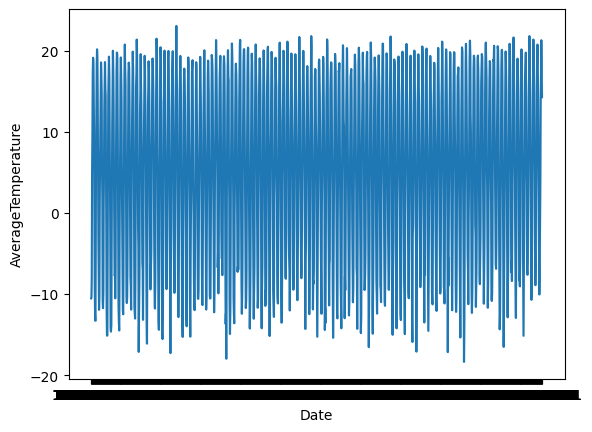

In [18]:
#Checking trends in Montreal over time
Montreal= df_data[['AverageTemperature', 'Date']].loc[df_data.CityName == 'Montreal']
sns.lineplot(y = Montreal.AverageTemperature ,x = Montreal.Date)

<AxesSubplot: xlabel='Date', ylabel='AverageTemperature'>

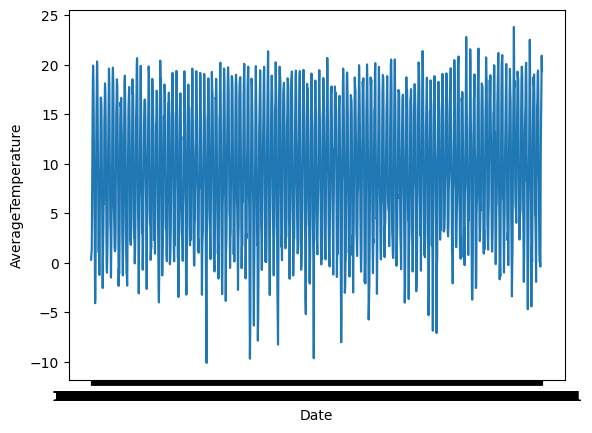

In [19]:
#Checking trends in Berlin over time
Berlin= df_data[['AverageTemperature', 'Date']].loc[df_data.CityName == 'Berlin']
sns.lineplot(y = Berlin.AverageTemperature ,x = Berlin.Date)

In [20]:
#Added month and year to the data
sql_statement = """SELECT ID, CAST(strftime('%Y',Date)  AS INT) AS Year,CAST(strftime('%m',Date)  AS INT) AS Month, CityName, Country, AverageTemperature, AverageTemperatureUncertainity, Latitude, Longitude FROM GlobalLandTemperatureByMajorCity glt
                INNER JOIN Country ON glt.CountryID = Country.CountryID 
                INNER JOIN MajorCities ON glt.CityID = MajorCities.CityID
                WHERE MajorCities.CityName IN ('Bangalore', 'Bangkok', 'Paris', 'Harbin', 'Montreal', 'Moscow', 'Kiev', 'Toronto', 
    'Saint Petersburg', 'Tokyo', 'Berlin', 'Istanbul', 'Karachi', 'Dhaka', 'Rome', 'NewYork', 'Durban', 
    'Kano', 'Baghdad', 'Melbourne', 'Madrid', 'London', 'Berlin', 'Taiyuan', 'Florida') 
"""
df_data2 = pd.read_sql_query(sql_statement, conn)
df_data2.Month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

<AxesSubplot: xlabel='Year', ylabel='AverageTemperature'>

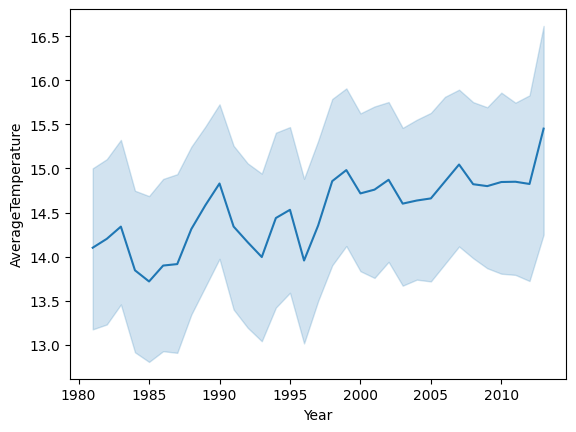

In [21]:
#Average temperature of all cities over time.
all_cities= df_data2[['AverageTemperature', 'Year']].loc[df_data2.Year > 1980]
sns.lineplot(y = all_cities.AverageTemperature ,x = all_cities.Year)

In [22]:
#Grouped dataframe by year
sql_statement = """SELECT ID, CAST(strftime('%Y',Date)  AS INT) AS Year, CityName, Country, AverageTemperature, AverageTemperatureUncertainity, Latitude, Longitude FROM GlobalLandTemperatureByMajorCity glt
                INNER JOIN Country ON glt.CountryID = Country.CountryID 
                INNER JOIN MajorCities ON glt.CityID = MajorCities.CityID
                WHERE MajorCities.CityName IN ('Bangalore', 'Bangkok', 'Paris', 'Harbin', 'Montreal', 'Moscow', 'Kiev', 'Toronto', 
    'Saint Petersburg', 'Tokyo', 'Berlin', 'Istanbul', 'Karachi', 'Dhaka', 'Rome', 'NewYork', 'Durban', 
    'Kano', 'Baghdad', 'Melbourne', 'Madrid', 'London', 'Berlin', 'Taiyuan', 'Florida') GROUP BY year
"""
df_data_by_year = pd.read_sql_query(sql_statement, conn)
df_data_by_year

,ID,Year,CityName,Country,AverageTemperature,AverageTemperatureUncertainity,Latitude,Longitude
0,1,1900,Tokyo,Japan,-0.57,0.43,36.17N,139.23E
1,1203,1901,Montreal,Canada,-12.34,0.31,45.81N,72.69W
2,2404,1902,Kiev,Ukraine,-1.28,1.03,50.63N,31.69E
3,3605,1903,Montreal,Canada,-11.73,0.87,45.81N,72.69W
4,4802,1904,Tokyo,Japan,-0.34,0.71,36.17N,139.23E
...,...,...,...,...,...,...,...,...
109,130803,2009,Berlin,Germany,-1.94,0.28,52.24N,13.14E
110,132005,2010,Saint Petersburg,Russia,-13.44,0.36,60.27N,29.19E
111,133203,2011,Montreal,Canada,-10.70,0.46,45.81N,72.69W
112,134406,2012,Harbin,China,-19.80,0.48,45.81N,125.77E


<AxesSubplot: xlabel='Year', ylabel='AverageTemperature'>

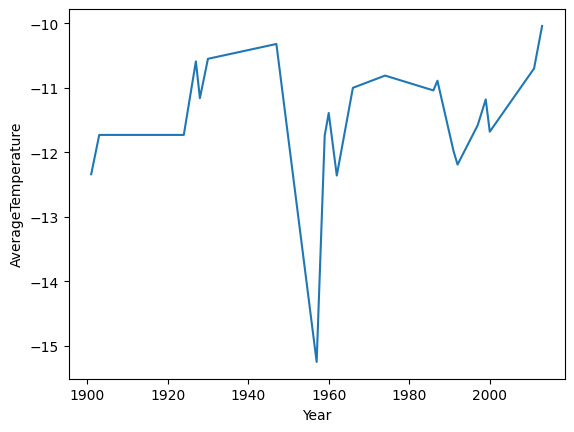

In [23]:
#Change in temperature of Montreal over the years
Montreal= df_data_by_year[['AverageTemperature', 'Year']].loc[df_data_by_year.CityName == 'Montreal']
sns.lineplot(y = Montreal.AverageTemperature ,x = Montreal.Year)

<AxesSubplot: xlabel='Year', ylabel='AverageTemperature'>

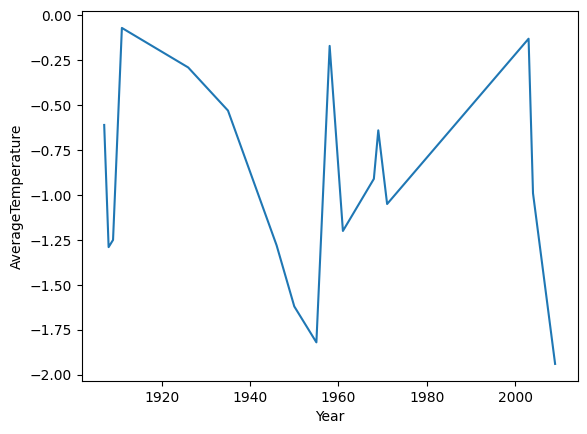

In [24]:
#Change in temperature of Berlin over the years
Berlin = df_data_by_year[['AverageTemperature', 'Year']].loc[df_data_by_year.CityName == 'Berlin']
sns.lineplot(y = Berlin.AverageTemperature ,x = Berlin.Year)

<AxesSubplot: xlabel='Year', ylabel='AverageTemperature'>

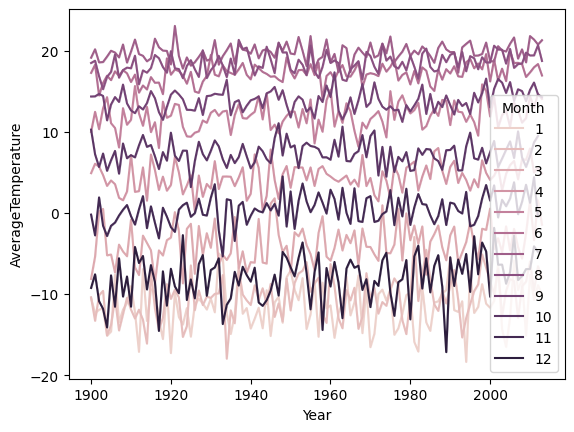

In [25]:
#Change in temperature per month over years in montreal
Montreal= df_data2[['AverageTemperature', 'Year', 'Month']].loc[df_data2.CityName == 'Montreal']
sns.lineplot(data=Montreal,
             x='Year', 
             y='AverageTemperature', 
             hue='Month', 
             legend='full')


<AxesSubplot: xlabel='Year', ylabel='AverageTemperature'>

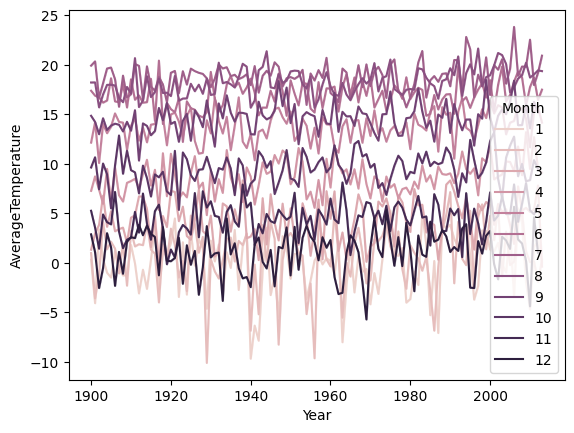

In [26]:
#Change in temperature in Berlin per month over the years
Berlin = df_data2[['AverageTemperature', 'Year', 'Month']].loc[df_data2.CityName == 'Berlin']
sns.lineplot(data=Berlin,
             x='Year', 
             y='AverageTemperature', 
             hue='Month', 
             legend='full')

### Time Series Forecasting using ARIMA Model <br> 
ARIMA: Autoregressive Integrated Moving Average <br>
- Only Stationary Series can be forecasted <br>
- If Stationarity condition is violated, the first step is to stationarize the series
<br>


Stationary time series is a series where the mean, variance of the time series is constant. <br>
To check for stationarity we perform Augmented Dickey Fuller Test. <br>
- Tests whether a time series is Non-Stationary or not. <br>
- Null hypothesis H0: Time series non stationary <br>
- Alternative hypothesis Ha : Time series is stationary <br>
- Rejection of null hypothesis means that the series is stationary.

In [29]:
#Data with top 20-25 cities
df_majorcities_query = '''Select Date, MajorCities.CityName, Country.Country, AverageTemperature, 
                            AverageTemperatureUncertainity 
	                        FROM GlobalLandTemperatureByMajorCity 
	                        INNER JOIN MajorCities ON GlobalLandTemperatureByMajorCity .CityID = MajorCities.CityID
	                        INNER JOIN Country ON GlobalLandTemperatureByMajorCity.CountryID=Country.CountryID
	                        WHERE MajorCities.CityName in ('Bangkok', 'Paris', 'Montreal', 'Moscow', 'Kiev', 'Toronto', 
                                'Saint Petersburg', 'Tokyo', 'Berlin', 'Istanbul', 'Dhaka', 'Rome', 
                                'Kano', 'Baghdad', 'Melbourne', 'Madrid', 'London', 'Berlin', 'Taiyuan', 'Bangalore', 'Harbin', 'Karachi', 'Durban')
	                        GROUP BY Date, MajorCities.CityName, Country.Country
	                        ORDER BY MajorCities.CityName, Country.Country'''

df_majorcities = pd.read_sql_query(df_majorcities_query, conn)
#print(df_majorcities)

Top20Cities = ['Bangkok', 'Paris', 'Montreal', 'Moscow', 'Kiev', 'Toronto', 
    'Saint Petersburg', 'Tokyo', 'Berlin', 'Istanbul', 'Dhaka', 'Rome', 
    'Kano', 'Baghdad', 'Melbourne', 'Madrid', 'London', 'Berlin', 'Taiyuan', 'Bangalore']

In [34]:
# Check Stationarity of the data.

import warnings


def checkStationarity(data):
    data.index = data['Date']
    pp.plot(data.index, data['AverageTemperature'])
    pp.title("Average Temperature from 1900 to 2013")
    pp.show()
    
    warnings.filterwarnings("ignore")
    # Function to print out results in customised manner
    from statsmodels.tsa.stattools import adfuller

    Temps = data['AverageTemperature'].values
    split = len(Temps)//2
    Temps1, Temps2 = Temps[0:split], Temps[split:]
    meanTemps1, meanTemps2 = Temps1.mean(), Temps2.mean()
    varTemps1, varTemps2 = Temps1.var(), Temps2.var()

    if abs(meanTemps1-meanTemps2) <= 10 and abs(varTemps1-varTemps2) <= 10:
        print('This indicates the given timeseries might be stationary as the mean and variance does not differ much.')
    else:
        print('Given timeseries might not be stationary.')

    #Performing Augmented Dickey-Fuller Test to confirm stationarity
    AdfullerResult = adfuller(Temps)
    print(AdfullerResult[1])
    p_value = AdfullerResult[1]
    if p_value < 0.05:
        return 'Time series is stationary'
    else:
        return 'Time series is not stationary'

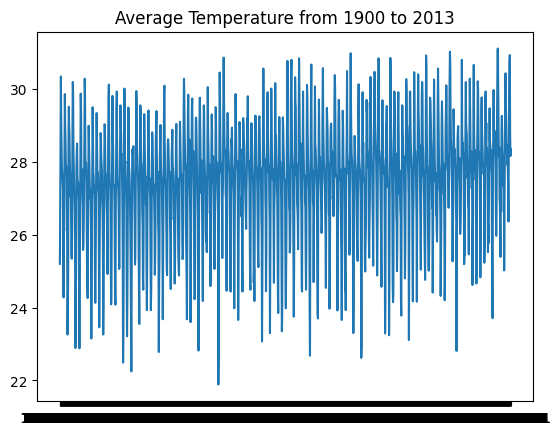

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.008984691858070224
For Bangkok :Time series is stationary


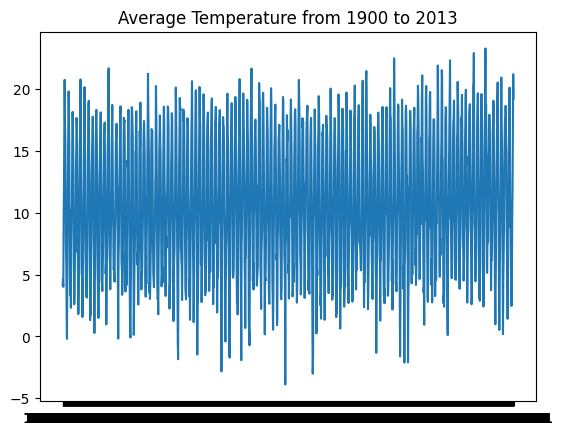

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.001579499393533814
For Paris :Time series is stationary


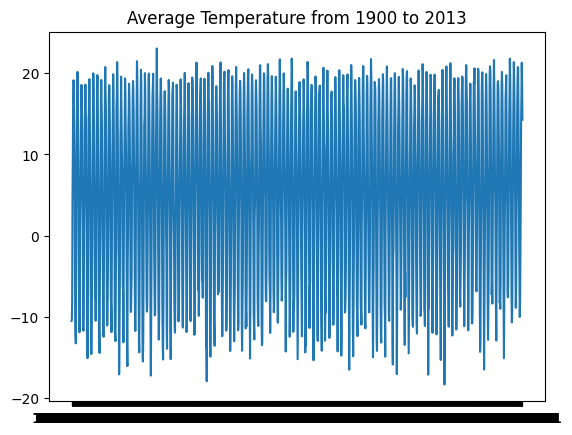

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.001260308867423435
For Montreal :Time series is stationary


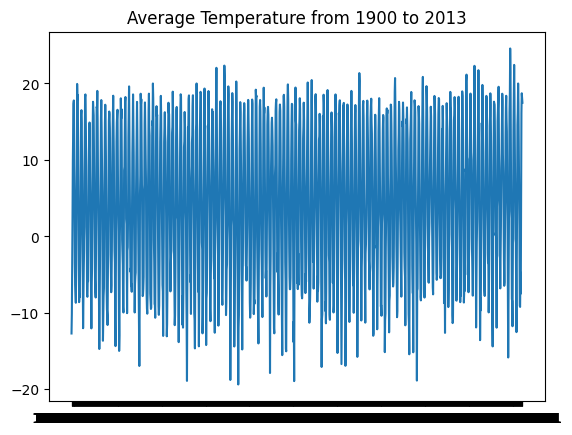

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
3.618027447222019e-05
For Moscow :Time series is stationary


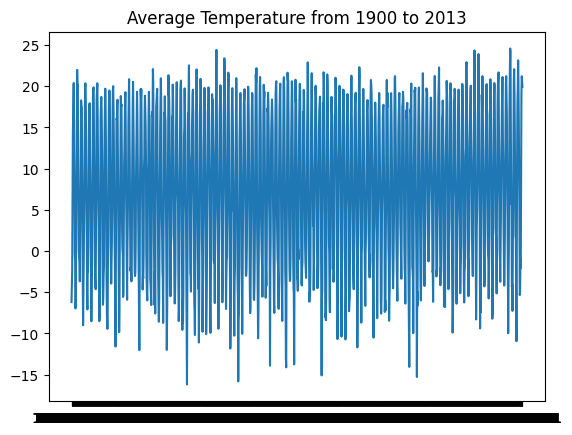

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.00012653816771237818
For Kiev :Time series is stationary


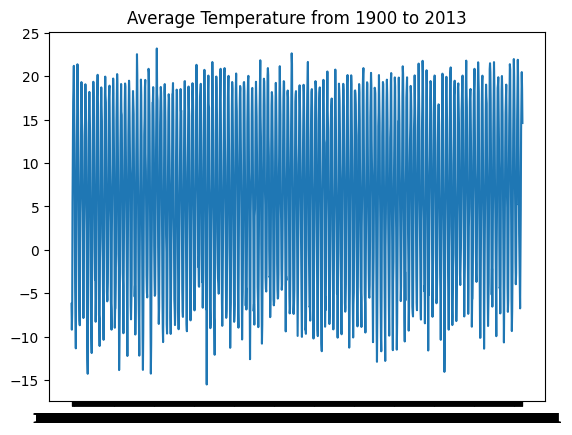

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.00048465407590177266
For Toronto :Time series is stationary


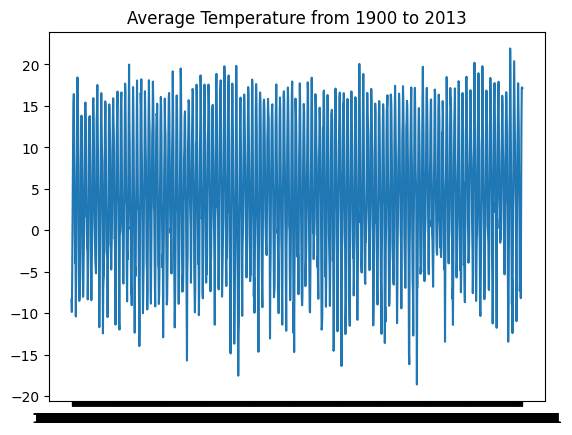

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
1.7333211705242409e-06
For Saint Petersburg :Time series is stationary


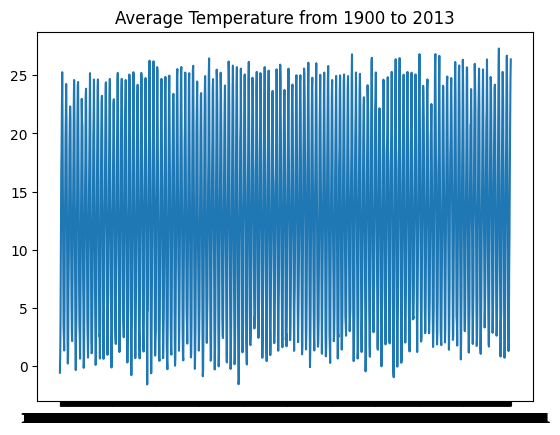

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.003762737503139213
For Tokyo :Time series is stationary


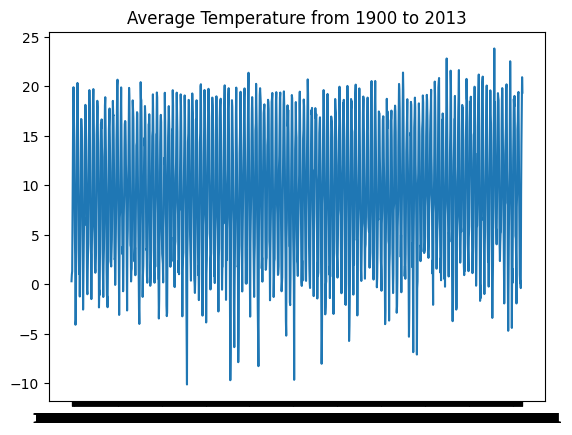

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.00012864866064311878
For Berlin :Time series is stationary


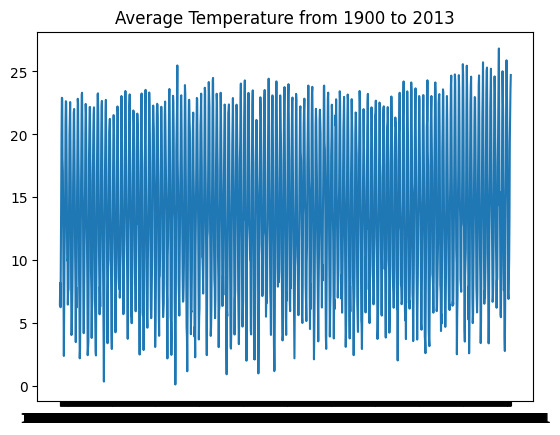

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
1.5250316405842935e-05
For Istanbul :Time series is stationary


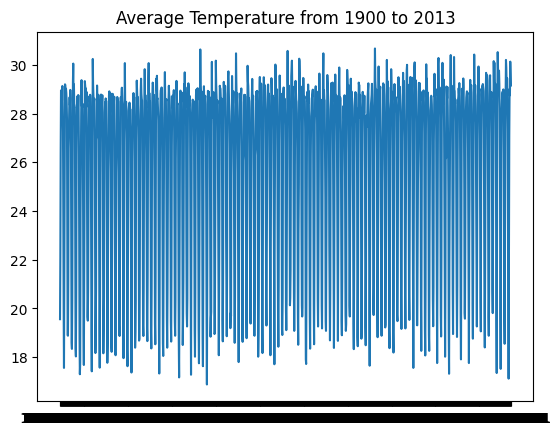

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.0032061725213075
For Dhaka :Time series is stationary


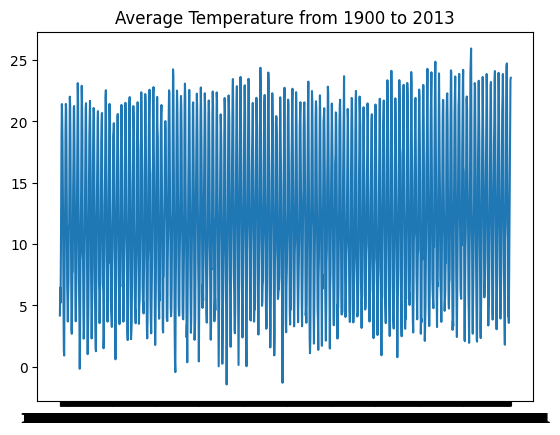

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.008033299810170369
For Rome :Time series is stationary


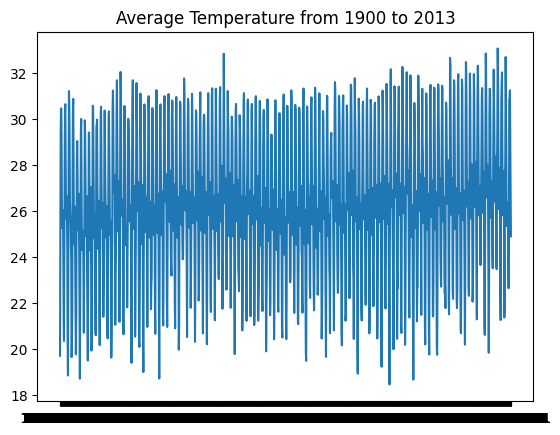

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.013178894868493036
For Kano :Time series is stationary


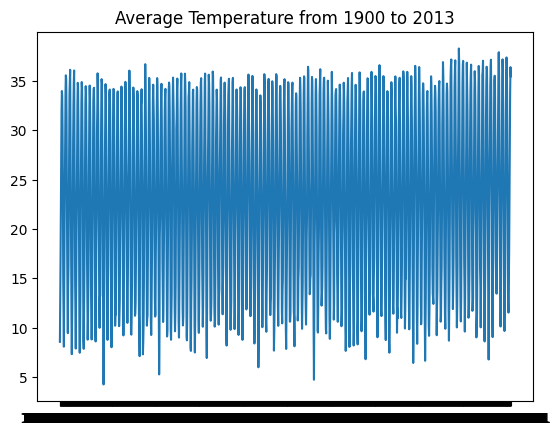

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.004583719058711593
For Baghdad :Time series is stationary


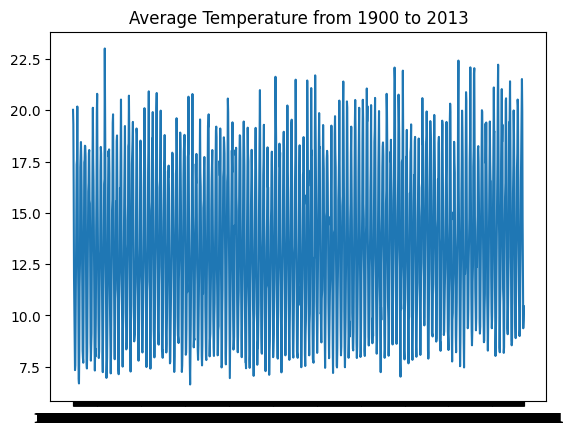

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.04014004189014241
For Melbourne :Time series is stationary


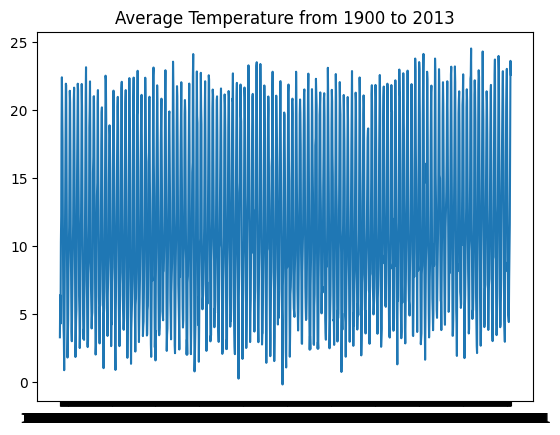

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.006403587394719924
For Madrid :Time series is stationary


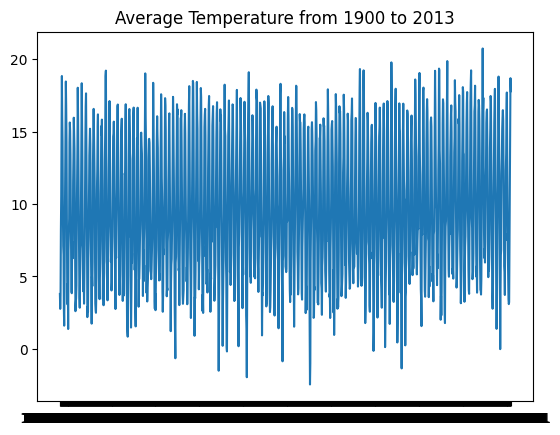

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.0013005645266157217
For London :Time series is stationary


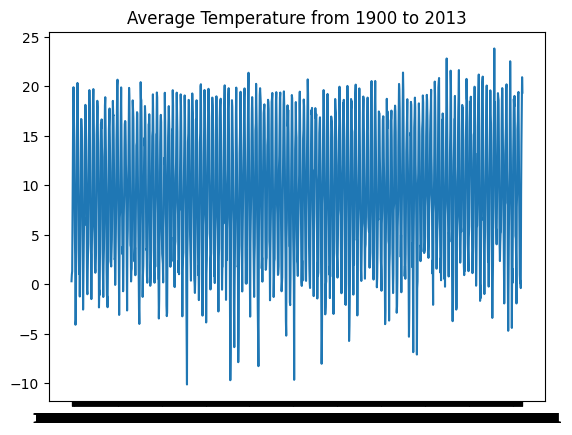

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.00012864866064311878
For Berlin :Time series is stationary


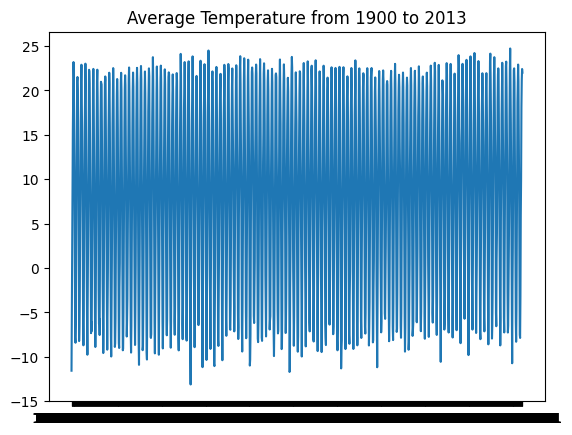

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.037503886308115346
For Taiyuan :Time series is stationary


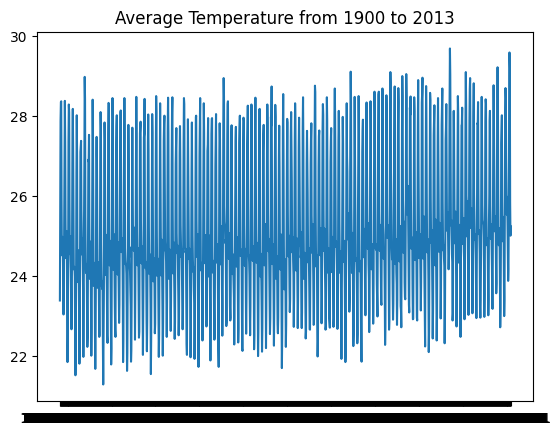

This indicates the given timeseries might be stationary as the mean and variance does not differ much.
0.02604889071579802
For Bangalore :Time series is stationary


In [35]:
#Checking stationarity of different cities
for c in Top20Cities:
    filter = df_majorcities.CityName == c
    city = df_majorcities.where(filter)
    print('For ' + c + ' :' + checkStationarity(city.dropna()))

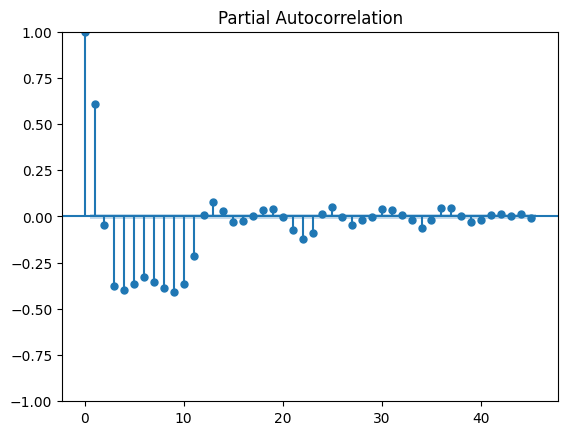

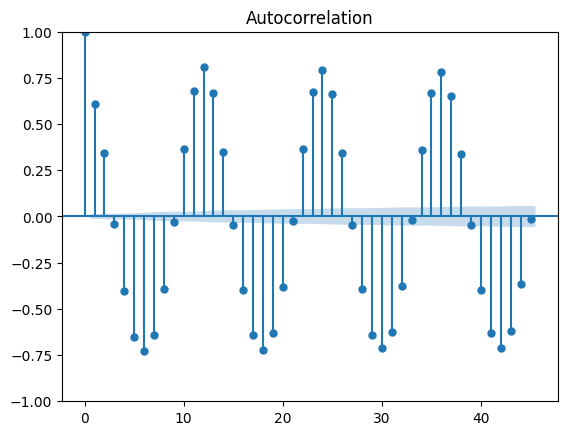

In [36]:
#Plotting ACF, PACF curves of the data
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
plot_pacf(df_majorcities['AverageTemperature'].diff().dropna())
pp.show()
plot_acf(df_majorcities['AverageTemperature'].diff().dropna())
pp.show()

In [37]:
#Applying ARIMA model on the data
def apply_arima_model(data):
    import warnings
    from pmdarima import auto_arima
    warnings.filterwarnings("ignore")
    # stepwise_fit = auto_arima(data['AverageTemperature'], suppress_warnings=True)

    # Our best mode, order is (0, 1, 1)
    shape = data.shape[0]

    # dividing into test and train
    train=data.iloc[:(int(0.7*shape))]
    test=data.iloc[-(int(0.3*shape)):]

    # building the model order = [p,d,q]
    from statsmodels.tsa.arima.model import ARIMA
    model=ARIMA(train['AverageTemperature'],order=(2,0,3))
    model=model.fit()
    print(model.summary())
    start = 0
    end = len(train)+len(test)-1
    pred = model.predict(start=start, end=len(train)+len(test)-1)
    pp.plot(data["Date"][:100], data['AverageTemperature'][:100], label="Original Values")
    pp.plot(data["Date"][start:end+1][:100], pred[:100], label="Predicted Values" )
    pp.legend(loc="upper left")
    pp.show()

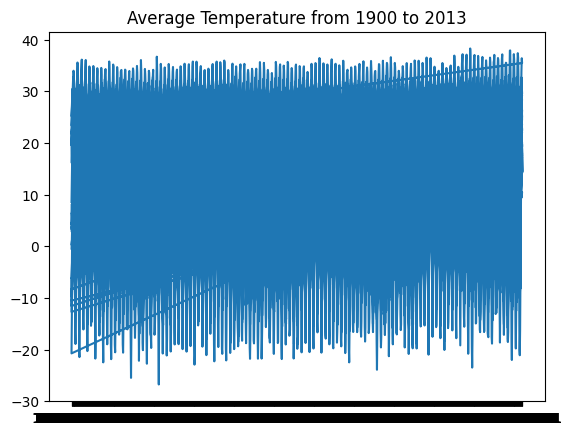

Given timeseries might not be stationary.
0.04555450424239894


'Time series is stationary'

In [38]:
checkStationarity(df_majorcities)

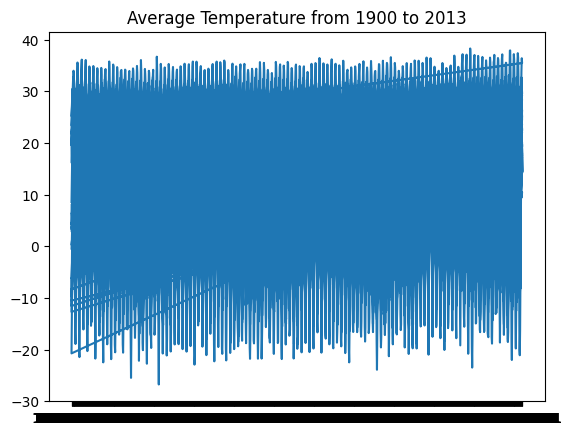

Given timeseries might not be stationary.
0.04555450424239894
                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                21007
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -51986.519
Date:                Sun, 18 Dec 2022   AIC                         103987.038
Time:                        17:13:24   BIC                         104042.706
Sample:                             0   HQIC                        104005.207
                              - 21007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.2455      0.210     77.215      0.000      15.833      16.658
ar.L1          1.4324      0.011    127.257      0.000       1.410   

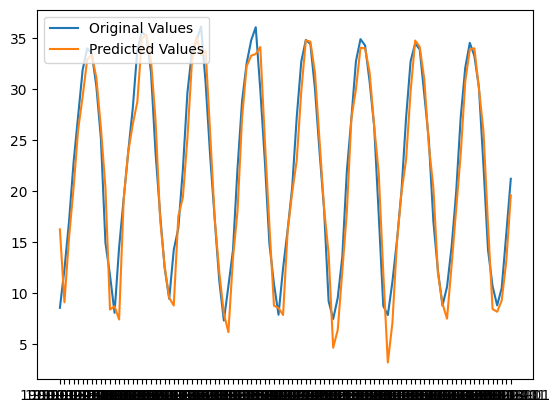

In [39]:
df_6majorcities_query = '''Select Date, MajorCities.CityName, Country.Country, AverageTemperature, 
                            AverageTemperatureUncertainity 
	                        FROM GlobalLandTemperatureByMajorCity 
	                        INNER JOIN MajorCities ON GlobalLandTemperatureByMajorCity .CityID = MajorCities.CityID
	                        INNER JOIN Country ON GlobalLandTemperatureByMajorCity.CountryID=Country.CountryID
	                        WHERE MajorCities.CityName in ('Bangkok', 'Paris', 'Montreal', 'Moscow', 'Kiev', 'Toronto')
	                        GROUP BY Date, MajorCities.CityName, Country.Country
	                        ORDER BY MajorCities.CityName, Country.Country'''
df_6majorcities = pd.read_sql_query(df_majorcities_query, conn)

checkStationarity(df_6majorcities)
apply_arima_model(df_6majorcities)

## Conclusion:
    
From the ablove graph the predicted values are closer to Original values. Using this model we will forecast the temperatures for the next few years and getting an inference about how the temperatures would vary in those cities.
